In [1]:
%load_ext autoreload
%autoreload 2

## This script is just to show Optuna works on graph models

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
#from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN, DeepGAT
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns
from patch_gnn.tune import evotune_mpnn_class, evotune_rf

In [3]:
from jax.config import config
config.update("jax_debug_nans", True)

## Load data and its asscociated graphs
##### Data is the raw data, while its associated graph,pkl has only sasa and fluc features. Loading its associated garph is necessary given graphs.pkl contains accession-sequence identifier needed to subset raw data for analysis 

In [5]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

##### An example of what metadata looks like for a node in a graph

In [6]:
graphs['P40121-VSDATGQMNLTK'].nodes(data=True)['312VAL']

{'chain_id': '',
 'residue_number': 312,
 'residue_name': 'VAL',
 'x_coord': 8.135,
 'y_coord': 35.62,
 'z_coord': 81.989,
 'features': None,
 'log_Phob/A^2': 2.9317269435780786,
 'log_Phil/A^2': 1.0784095813505903,
 'log_SASA/A^2': 3.077312260546414,
 'log_N(overl)': 6.159095388491933,
 'anm': 0.408609008319972,
 'nma': 0.119027078014224}

In [7]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


##### Split data in to train and test

In [8]:
train_df, test_df = train_test_split(key, processed_data) # 70% training, 30% testing
(train_df.shape), (test_df.shape) #359 total raw data points

((251, 18), (108, 18))

Note that this the num of train + test samples  = total graphs

In [50]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])

def plot_performance(
    model,
    trainX, trainY, testX, testY,
    model_name: str,
    ev_func,
    checkpoint: int = None,
):
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
    # evaluate model is MPNN class, b/c other deep learning models inhert from this class, they are all under this class
    if isinstance(model, MPNN):
        train_preds = model.predict(trainX, checkpoint=checkpoint)
    else:
        train_preds = model.predict(trainX)
    print(ev_func(trainY.squeeze(), train_preds.squeeze()))
    ax[0].scatter(trainY, train_preds.squeeze())
    ax[0].set_title(f"Model: {model_name}, Training Perf: {ev_func(trainY.squeeze(), train_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[0])

    if isinstance(model, MPNN):
        test_preds = model.predict(testX, checkpoint=checkpoint)
    else:
        test_preds = model.predict(testX)
    ax[1].scatter(testY, test_preds.squeeze())
    ax[1].set_title(f"Model: {model_name}, Validation Perf: {ev_func(testY.squeeze(), test_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[1])

## Deep learning related model of interests
- Graph based models
    - Massage passing neural network (MPNN)
    - Deep message passing neural network (DMPNN)
    - Deep graph attention neural network (DeepGAT)

In [11]:
train_graph = graph_tensors(train_df, graphs) # use graph + sasa features + fluc features
test_graph = graph_tensors(test_df, graphs)

# get an idea of the output dim of graph_tensors
adjs, feats = graph_tensors(train_df, graphs)
print(adjs.shape, feats.shape) # adjs: (n_sample, n_node, n_node, 1), feats: (n_sample, n_node, n_feature)

(251, 20, 20, 1) (251, 20, 67)


In [12]:
#load target value
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

### Define training for non-linear models

In [17]:
num_training_steps = 5000
node_feature_shape = (20,67)
num_adjacency =1
#num_training_steps = 5 # put it here and later it would be overwritten by optuna
deep_models = {
    "mpnn": MPNN(
        node_feature_shape=node_feature_shape,# (num_nodes is number of unique animo acid, num_feats from data/amino_acid_properties.csv + 4 sasa_dfs features +2 fluc features )
        num_adjacency=num_adjacency,
        num_training_steps=num_training_steps
    ),
    "deep_mpnn": DeepMPNN(
        node_feature_shape=node_feature_shape,
        num_adjacency=num_adjacency,
        num_training_steps=num_training_steps
    ),
    #"deep_gat": DeepGAT(
    #    node_feature_shape = node_feature_shape,
    #    num_adjacency = num_adjacency,
    #    num_training_steps=num_training_steps
    #)
}


In [18]:
for deep_model in deep_models.keys():
    print(f"training {deep_model} model now")
    deep_models[deep_model].fit(train_graph, train_target)

training mpnn model now


  0%|          | 0/5000 [00:00<?, ?it/s]

training deep_mpnn model now


  0%|          | 0/5000 [00:00<?, ?it/s]

0.406440465451818
0.4064404754321955
0.4271069504053683
0.4271069778745705


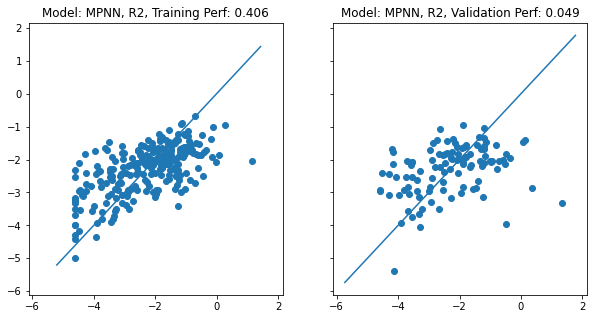

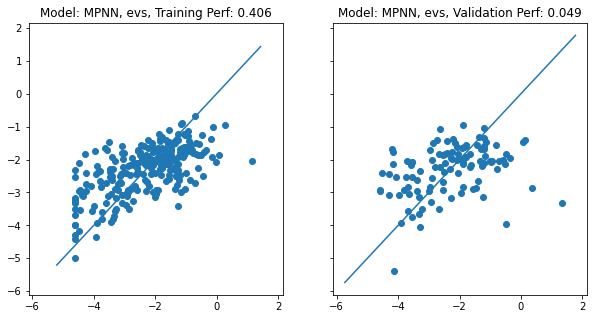

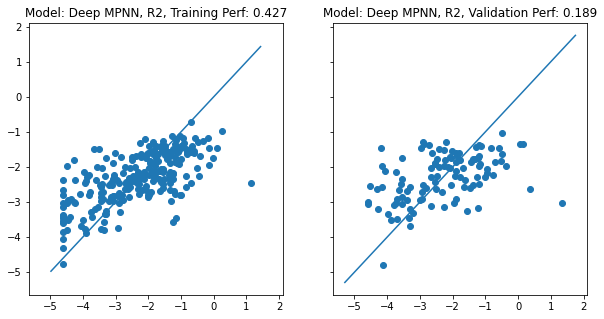

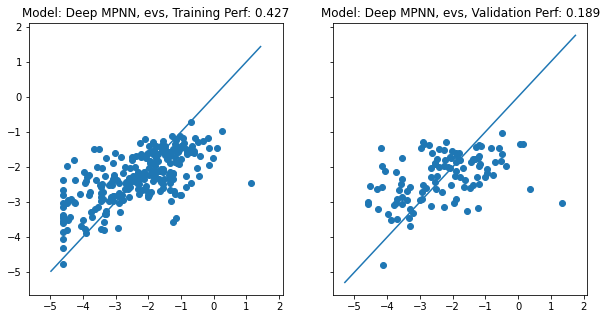

In [58]:
from scipy.stats import pearsonr,spearmanr
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, R2', r2_score, checkpoint=300)
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs', evs, checkpoint=300)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, R2',  r2_score, checkpoint=400)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs',  evs, checkpoint=400)

### deep models hyperparameter tunning

In [17]:
num_training_steps_kwargs = {
    "name": "num_training_steps",
    "low": 4,
    "high": 500,
    "log": True,
}
#num_training_steps_kwargs={}
optimizer_step_size_kwargs={
    "name" : "optimizer_step_size",# this key value pair is required as is
    "low" : 1e-5, # one can change the value
    "high" : 1e-2, # one can change the value
} 


In [18]:
evotune_mpnn_class(deep_models['mpnn'], train_graph, train_target, num_training_steps_kwargs, optimizer_step_size_kwargs, n_trials = 1 )

[I 2021-07-06 16:02:21,156] A new study created in memory with name: no-name-75c19d1d-4c13-4793-9da4-5ddaa23ac0dd


The params that were optimized is {'num_training_steps': 4, 'optimizer_step_size': 0.005263207454577327}


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2021-07-06 16:02:22,593] Trial 0 finished with value: 10.531705856323242 and parameters: {'num_training_steps': 4, 'optimizer_step_size': 0.005263207454577327}. Best is trial 0 with value: 10.531705856323242.


{'num_training_steps': 4, 'optimizer_step_size': 0.005263207454577327}

## start training all models

In [ ]:
for deep_model in deep_models.keys():
    print(f"training {deep_model} model now")
    deep_models[deep_model].fit(train_graph, train_target)

In [ ]:
deep_models["mpnn"].loss_history[:5]

In [ ]:
## train gat model more

In [ ]:
deep_models["deep_gat"].fit(train_graph, train_target)

## Which checkpoint for NN models?

In [ ]:
plt.plot(deep_models["mpnn"].loss_history)
plt.yscale("log")

In [ ]:
plt.plot(deep_models["deep_mpnn"].loss_history)
plt.yscale("log")

In [ ]:
plt.plot(deep_models["deep_gat"].loss_history)
plt.yscale("log")

## Checkpoint at 400 steps

In [ ]:
checkpoint = 400
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)

## Checkpoint at 600 steps

In [ ]:
checkpoint = 600
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


In [ ]:
isinstance(deep_models["deep_gat"], MPNN)

In [ ]:
checkpoint = 1000
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


## Checkpoint at Final steps

In [ ]:
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs', evs, checkpoint=-1)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs',  evs, checkpoint=-1)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep GAT, evs', evs, checkpoint=-1)